In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
import random

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


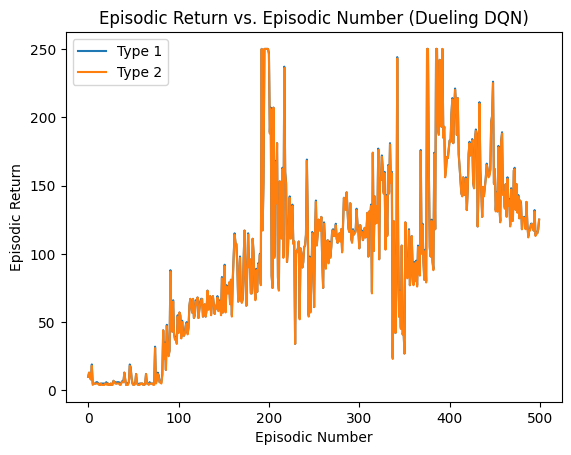

In [16]:
# Dueling DQN Network - Type 1
class DuelingDQN_Type1(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingDQN_Type1, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.feature_layer = nn.Sequential(
            nn.Linear(state_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU()
        )

        self.value_stream = nn.Sequential(
            nn.Linear(32, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(32, action_dim)
        )

    def forward(self, x):
        x = self.feature_layer(x)
        values = self.value_stream(x)
        advantages = self.advantage_stream(x)
        q_values = values + (advantages - advantages.mean(dim=-1, keepdim=True))
        return q_values

# Dueling DQN Network - Type 2
class DuelingDQN_Type2(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingDQN_Type2, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.feature_layer = nn.Sequential(
            nn.Linear(state_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU()
        )

        self.value_stream = nn.Sequential(
            nn.Linear(32, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(32, action_dim)
        )

    def forward(self, x):
        x = self.feature_layer(x)
        values = self.value_stream(x)
        advantages = self.advantage_stream(x)
        q_values = values + torch.maximum(advantages - advantages.mean(dim=-1, keepdim=True), torch.tensor(0.))
        return q_values

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Function to select actions using epsilon-greedy policy
def select_action(state, epsilon, model):
    if np.random.rand() < epsilon:
        return np.random.randint(model.action_dim)
    else:
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0)
            q_values = model(state)
            return q_values.argmax().item()

# Hyperparameters
EPISODES = 500
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995
TARGET_UPDATE = 10
CAPACITY = 10000
LR = 0.001

# Create environment
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Initialize Dueling DQN - Type 1
model_type1 = DuelingDQN_Type1(state_dim, action_dim)
target_model_type1 = DuelingDQN_Type1(state_dim, action_dim)
target_model_type1.load_state_dict(model_type1.state_dict())
target_model_type1.eval()

# Initialize Dueling DQN - Type 2
model_type2 = DuelingDQN_Type2(state_dim, action_dim)
target_model_type2 = DuelingDQN_Type2(state_dim, action_dim)
target_model_type2.load_state_dict(model_type2.state_dict())
target_model_type2.eval()

# Initialize optimizer and loss function for Type 1
optimizer_type1 = optim.Adam(model_type1.parameters(), lr=LR)
loss_fn_type1 = nn.MSELoss()

# Initialize optimizer and loss function for Type 2
optimizer_type2 = optim.Adam(model_type2.parameters(), lr=LR)
loss_fn_type2 = nn.MSELoss()

# Initialize replay buffer
replay_buffer = ReplayBuffer(CAPACITY)

# Lists to store returns
returns_type1 = []
returns_type2 = []

# Training loop
for episode in range(EPISODES):
    state = env.reset()
    done = False
    total_reward_type1 = 0
    total_reward_type2 = 0

    while not done:
        # Type 1
        epsilon = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * episode / EPS_DECAY)
        action_type1 = select_action(state, epsilon, model_type1)
        next_state, reward, done, _ = env.step(action_type1)
        total_reward_type1 += reward

        replay_buffer.push((state, action_type1, reward, next_state, done))

        if len(replay_buffer) > BATCH_SIZE:
            transitions = replay_buffer.sample(BATCH_SIZE)
            batch = list(zip(*transitions))
            state_batch = torch.FloatTensor(batch[0])
            action_batch = torch.LongTensor(batch[1])
            reward_batch = torch.FloatTensor(batch[2])
            next_state_batch = torch.FloatTensor(batch[3])
            done_batch = torch.FloatTensor(batch[4])

            q_values = model_type1(state_batch)
            next_q_values = target_model_type1(next_state_batch)

            q_value = q_values.gather(1, action_batch.unsqueeze(1)).squeeze(1)
            next_q_value = next_q_values.max(1)[0]
            expected_q_value = reward_batch + GAMMA * next_q_value * (1 - done_batch)

            loss_type1 = loss_fn_type1(q_value, expected_q_value.detach())

            optimizer_type1.zero_grad()
            loss_type1.backward()
            optimizer_type1.step()

        # Type 2
        epsilon = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * episode / EPS_DECAY)
        action_type2 = select_action(state, epsilon, model_type2)
        next_state, reward, done, _ = env.step(action_type2)
        total_reward_type2 += reward

        replay_buffer.push((state, action_type2, reward, next_state, done))

        if len(replay_buffer) > BATCH_SIZE:
            transitions = replay_buffer.sample(BATCH_SIZE)
            batch = list(zip(*transitions))
            state_batch = torch.FloatTensor(batch[0])
            action_batch = torch.LongTensor(batch[1])
            reward_batch = torch.FloatTensor(batch[2])
            next_state_batch = torch.FloatTensor(batch[3])
            done_batch = torch.FloatTensor(batch[4])

            q_values = model_type2(state_batch)
            next_q_values = target_model_type2(next_state_batch)

            q_value = q_values.gather(1, action_batch.unsqueeze(1)).squeeze(1)
            next_q_value = next_q_values.max(1)[0]
            expected_q_value = reward_batch + GAMMA * next_q_value * (1 - done_batch)

            loss_type2 = loss_fn_type2(q_value, expected_q_value.detach())

            optimizer_type2.zero_grad()
            loss_type2.backward()
            optimizer_type2.step()

        state = next_state

    if episode % TARGET_UPDATE == 0:
        target_model_type1.load_state_dict(model_type1.state_dict())
        target_model_type2.load_state_dict(model_type2.state_dict())

    returns_type1.append(total_reward_type1)
    returns_type2.append(total_reward_type2)

# Plot episodic return versus episodic number for both types
plt.plot(range(EPISODES), returns_type1, label='Type 1 Dueling DQN')
plt.plot(range(EPISODES), returns_type2, label='Type 2 Dueling DQN')
plt.xlabel('Episodic Number')
plt.ylabel('Episodic Return')
plt.title('Episodic Return vs. Episodic Number (Dueling DQN) - CartPole Environment')
plt.legend()
plt.show()


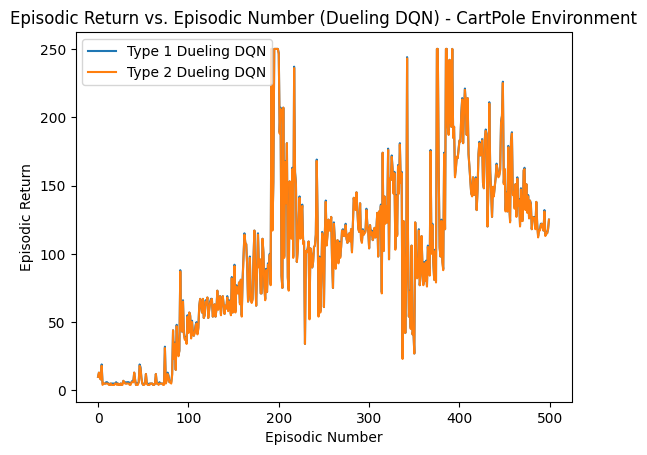

In [17]:
# Plot episodic return versus episodic number for both types
plt.plot(range(EPISODES), returns_type1, label='Type 1 Dueling DQN')
plt.plot(range(EPISODES), returns_type2, label='Type 2 Dueling DQN')
plt.xlabel('Episodic Number')
plt.ylabel('Episodic Return')
plt.title('Episodic Return vs. Episodic Number (Dueling DQN) - CartPole Environment')
plt.legend()
plt.show()